# Cough Extraction Based on Time Domain

This notebook detects the coughs in a recording based on certain thresholds and parameters in the time domain. 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
import math
import os

## Loading Audio Data and Corresponding Timestamps

In [22]:
# Extracts timestamps from a .txt file
# Each line in the file contains a start and finish time separated by a tab.

def get_real_timestamps(audio_timestamp_file):
    
    """
    Parses a .txt file containing timestamp information.
    
    Parameters:
        audio_timestamp_file (str): Path to the .txt file.
    
    Returns:
        list: List of tuples, each containing start and finish times.
    """
    
    timestamps = []

    with open(audio_timestamp_file, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                start, end = map(float, line.split("\t"))
                timestamps.append((start, end))

    return timestamps

In [23]:
# Cough audio loading

# Directory paths for audio and corresponding timestamps
audio_dir = '../recordings-and-timestamps/audio-recordings/cough-recordings/'
timestamp_dir = '../recordings-and-timestamps/audio-timestamps/cough-timestamps/'

# List all .wav files in the audio directory
audio_files = [file for file in os.listdir(audio_dir) if file.endswith('.wav')]

# Choose an index to work with a specific audio file
index = 6
audio_file = audio_files[index]

base_name = os.path.splitext(audio_file)[0]
timestamp_file = base_name + '-label.txt'
           
# Form complete file paths for audio and timestamp files
audio_path = os.path.join(audio_dir, audio_file)
timestamp_path = os.path.join(timestamp_dir, timestamp_file)
print(audio_path)

data, sample_rate = librosa.load(audio_path, sr=48000)

# Retrieve the actual cough timestamps from the corresponding timestamp file
real_timestamps = get_real_timestamps(timestamp_path)

# Display the duration of the audio and its sample rate
duration = librosa.get_duration(path=audio_path)
print("Audio Duration: {}".format(duration))
print("Sample Rate: {}".format(sample_rate))


../recordings-and-timestamps/audio-recordings/cough-recordings/2024-03-05T16-33-55.wav
Audio Duration: 60.3
Sample Rate: 48000


In [24]:
# The audio
Audio(audio_path)

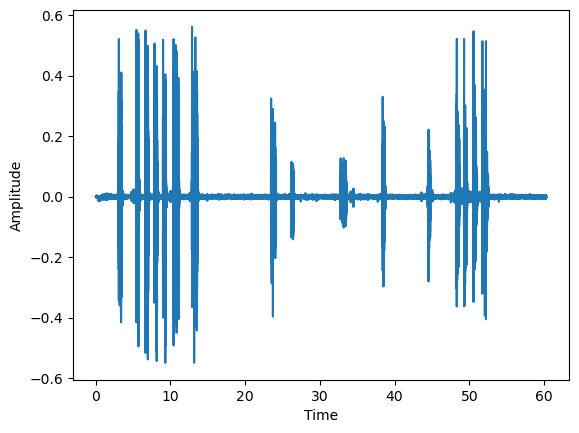

In [33]:
# Data graph
time = np.arange(0, len(data)) / sample_rate

plt.plot(time, data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Data Preprocessing Functions

In [26]:
# Function to normalize the given data

def normalize_data(data):

    # Find the minimum and maximum values in the data
    data_min = np.min(data)
    data_max = np.max(data)

    # Normalize the data using min-max scaling
    normalized_data = (data - data_min) / (data_max - data_min)

    return normalized_data

In [27]:
def compute_moving_average(data, window_size=15):

    """
    Computes the moving average of the input data using a specified window size.

    Parameters:
    - data (array-like): Input data to compute the moving average.
    - window_size (int, optional): Size of the moving average window. Defaults to 15.

    Returns:
    - array: Array containing the moving averages.

    Note:
    The moving average is computed using a simple convolution with a kernel of ones.
    """
    kernel = np.ones(window_size) / window_size
    moving_averages = np.convolve(data, kernel, mode='valid')
    moving_averages = np.round(moving_averages, 2)
    
    return moving_averages

In [28]:
# This function designs a Butterworth bandpass filter and applies it to the input data.

def butter_bandpass(lowcut, highcut, fs, order=8):
    
    """
    Design a Butterworth bandpass filter.

    Parameters:
    - lowcut (float): The low cutoff frequency.
    - highcut (float): The high cutoff frequency.
    - fs (float): The sampling frequency of the signal.
    - order (int): The order of the filter (default is 8).

    Returns:
    - sos (ndarray): Second-order sections (SOS) representation of the filter.
    """

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
    
    """
    Apply a Butterworth bandpass filter to the input data.

    Parameters:
    - data (array_like): Input data to be filtered.
    - lowcut (float): The low cutoff frequency.
    - highcut (float): The high cutoff frequency.
    - fs (float): The sampling frequency of the signal.
    - order (int): The order of the filter (default is 8).

    Returns:
    - y (array_like): Filtered output data.
    """

    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [29]:
# Preprocesses the input data by applying a bandpass filter, computing moving average, and normalizing the data.
def preprocess_data(data):
    
    """
    Parameters:
    - data (ndarray): Input data to be preprocessed.
        
    Returns:
    - ndarray: Preprocessed data.

    Note:
    - This function applies a bandpass filter, computes the moving average, and normalizes the data.
    """

    # Apply bandpass filter to remove unwanted frequencies
    filtered_data = butter_bandpass_filter(data, lowcut=1000, highcut=4000, fs=sample_rate, order=8)

    # Compute moving average of the absolute values of the filtered data
    averaged_data = compute_moving_average(np.abs(filtered_data))

    # Normalize the data
    normalized_data = normalize_data(averaged_data)

    # Flatten the data
    flattened_data = normalized_data.flatten()

    return flattened_data

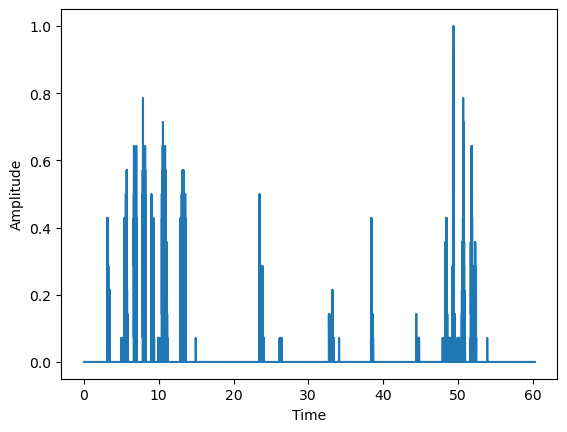

In [30]:
# Preprocessed Data

preprocessed_data = preprocess_data(data)
time_preprocessed_data = np.arange(len(preprocessed_data)) / sample_rate

# Plotting the graph

#plt.plot(time_data, data)
plt.plot(time_preprocessed_data, preprocessed_data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Cough Detection

Maximum Magnitude:  1.0
Average Magnitude:  0.011516580225107697
Standard Deviation:  0.04645191585085328


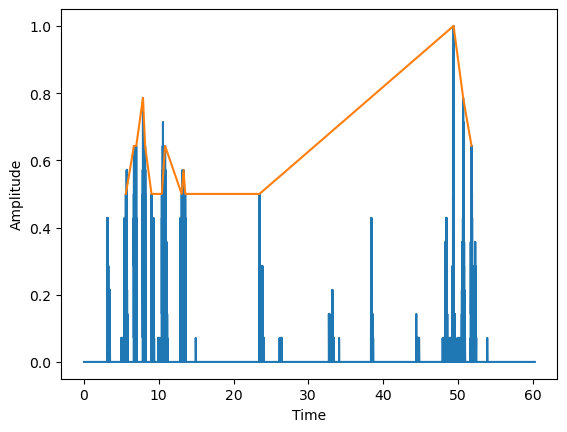


Cough Count: 15
Cough Timestamps: [5.599438, 6.688125, 6.997146, 7.8935, 8.179479, 9.033958, 10.412917, 10.851667, 13.069167, 13.322604, 13.544062, 23.476208, 49.430417, 50.715042, 51.8315]
Cough Indices: [268773, 321030, 335863, 378888, 392615, 433630, 499820, 520880, 627320, 639485, 650115, 1126858, 2372660, 2434322, 2487912]


In [31]:
# Finding the number of coughs with a threshold

# Calculate maximum magnitude, average magnitude, and standard deviation of the preprocessed data
max_value = np.max(preprocessed_data)
mean_value = np.mean(preprocessed_data)
std = np.std(preprocessed_data)

print("Maximum Magnitude: ", max_value)
print("Average Magnitude: ", mean_value)
print("Standard Deviation: ", std)

# Define the percentile threshold for peak detection
percentile_threshold = 99.8
threshold = np.percentile(preprocessed_data, percentile_threshold)

# Find peaks in the preprocessed data using specified prominence and height threshold
cough_indices, _ = find_peaks(preprocessed_data, prominence=0.5, height=threshold)
cough_indices = list(cough_indices)

# Deleting overlaps in the peaks - Avoiding counting the same cough more than once
i = 0
while i < len(cough_indices):
    peak = cough_indices[i]
    peak_range = (peak - 4800, peak + 4800) 
    
    # Find overlapping indices within a certain range around the peak
    overlap_indices = [index for index in cough_indices if peak_range[0] < index < peak_range[1]]
 
    if len(overlap_indices) > 1:
        
        # Find the index with maximum amplitude among overlapping indices
        max_index = overlap_indices[0]
        for index in overlap_indices:
            if preprocessed_data[index] > preprocessed_data[max_index]:
                max_index = index
        
        overlap_indices.remove(max_index)
        
        for element in overlap_indices:
            cough_indices.remove(element)
        
    i += 1
    
# Convert peak indices to timestamps based on the sampling rate
predicted_timestamps = [round(index / sample_rate, 6) for index in cough_indices]

# Remove closely occurring coughs to avoid double counting
for ts in predicted_timestamps:
    matches = [ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.2]
    
    if len(matches) != 0:
        for match in matches:
            index = predicted_timestamps.index(match)
            predicted_timestamps.remove(match)
            cough_indices.remove(cough_indices[index])

# Plot preprocessed data with detected coughs
upper_envelope = preprocessed_data[cough_indices]
time = np.arange(0, len(preprocessed_data)) / sample_rate
time_envelope = time[cough_indices]

plt.plot(time, preprocessed_data)
plt.plot(time_envelope, upper_envelope)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Count the number of detected coughs
cough_count = len(cough_indices)

# Display the results
print("\nCough Count: {}".format(cough_count))
print("Cough Timestamps: {}".format([round(timestamp, 6) for timestamp in predicted_timestamps]))
print("Cough Indices: {}".format(cough_indices))


## Performance Measurement According to the Detected and Missed Coughs

In [32]:
# This script is designed to evaluate the performance of a model that predicts timestamps for cough events. 
# It compares the predicted timestamps with the actual timestamps of cough events to calculate precision, recall, and F1-score.

# Margin of error allowed in matching timestamps, in seconds
time_margin = 0.40

# Display the lists of predicted and actual cough timestamps
print(predicted_timestamps, "\n")
print()
print(real_timestamps, "\n")

# Initialize counters for true positives and false positives
true_positive = 0 
false_positive = 0

# Determine the longer list between predicted and actual cough timestamps

if len(predicted_timestamps) > len(real_timestamps):
    for pred in predicted_timestamps:

        # Check for matches between the predicted timestamp and actual cough timestamps within a margin of error
        match = list((rt for rt in real_timestamps if pred - time_margin < rt[0] < pred + time_margin or pred - time_margin < rt[1] < pred + time_margin))

        if len(match) != 0:
            true_positive += 1
        else:
            false_positive += 1

else:

    for pred in real_timestamps:

        # Check for matches between the actual timestamp and predicted cough timestamps within a margin of error
        match = list((rt for rt in predicted_timestamps  if pred[0] - time_margin < rt < pred[0] + time_margin or pred[1] - time_margin < rt < pred[1] + time_margin))

        if len(match) != 0:
            true_positive += 1
        else:
            false_positive += 1
            
# Calculate precision
precision = true_positive / (true_positive + false_positive)

# Recall is assumed as 1 since the model does not predict the absence of coughs
recall = 1

# Calculate F1-score using precision and recall
f1_score = 2 * (precision * recall) / (precision + recall)

# Display the F1-score
print(f1_score)

[5.599438, 6.688125, 6.997146, 7.8935, 8.179479, 9.033958, 10.412917, 10.851667, 13.069167, 13.322604, 13.544062, 23.476208, 49.430417, 50.715042, 51.8315] 


[(3.086014, 3.647722), (5.400705, 6.017139), (6.612213, 7.228647), (7.830633, 8.471146), (8.98163, 9.583616), (10.406372, 10.78808), (10.803503, 11.273891), (12.860209, 13.273788), (13.29492, 13.774914), (23.441357, 23.793802), (23.807623, 24.182181), (32.733097, 33.082777), (33.147738, 33.685388), (38.372207, 38.799287), (44.386688, 44.921111), (48.274107, 48.716603), (49.2557, 49.741822), (50.511515, 51.09268), (51.705007, 52.155293), (52.180223, 52.582208)] 

0.8235294117647058
